# ADS 509 Module 3: Group Comparison

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following:

- Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set.
- Calculate descriptive statistics on the two sets of lyrics and compare the results.
- For each of the four corpora, find the words that are unique to that corpus.
- Build word clouds for all four corpora.

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization).


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. _Make sure to answer every question marked with a `Q:` for full credit._


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud

In [2]:
# Use this space for any additional import statements you need
from pathlib import Path

In [3]:
def display_counter(tokens, top=10, header="words", header2="count", show=True):
    """
    Display or return the most common tokens in a list.

    Parameters
    ----------
    tokens : list
        A list of tokens (strings or other hashable objects) to be counted.
    top : int, optional, default=10
        Number of most common tokens to return or display.
    header : str, optional, default="words"
        Column name for the token column in the output DataFrame.
    header2 : str, optional, default="count"
        Column name for the count column in the output DataFrame.
    show : bool, optional, default=True
        If True, prints and displays a pandas DataFrame of the results.
        If False, returns the data as a list of tuples.

    Returns
    -------
    None or list of tuple
        If `show=True`, the function displays the DataFrame and returns None.
        If `show=False`, it returns a list of (token, count) tuples.

    Docstring generated with assistance from ChatGPT
    """
    data = Counter(tokens).most_common(top)
    df = pd.DataFrame(data, columns=[header, header2])

    if show:
        print(f"\nThe top {top} most common {header}:")
        display(df)
        return None
    else:
        return data


def get_token_list(dataframe, artist_name, column):
    """
    Extract and flatten all tokens for a given artist from a DataFrame column.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The input DataFrame containing at least an "artist" column and a tokenized column.
    artist_name : str
        The name of the artist used to filter the DataFrame.
    column : str
        The name of the column containing lists of tokens.

    Returns
    -------
    list
        A flat list of tokens aggregated across all rows for the specified artist.

    Docstring generated with assistance from ChatGPT
    """
    token_list = []
    artist_rows = dataframe[dataframe["artist"] == artist_name]
    lists = artist_rows[column].tolist()
    for list in lists:
        token_list.extend(list)
    return token_list


# Some punctuation variations
punctuation = set(punctuation)  # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA:
    for em in emoji.EMOJI_DATA[country]:
        all_language_emojis.add(em)


# and now our functions
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, print number of tokens, number of unique tokens,
    number of characters, lexical diversity, and num_tokens most common
    tokens. Return a list of
    """

    # Place your Module 2 solution here
    def count_char_of_token(token_list):
        total = 0
        for token in token_list:
            total += len(token)

        return total

    def lex_diversity(unique, total):
        lex_div = 0
        if total > 0:
            lex_div = unique / total

        return lex_div

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = lex_diversity(num_unique_tokens, num_tokens)
    num_characters = count_char_of_token(tokens)

    if verbose:
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        # print the five most common tokens
        display_counter(tokens, top=5, header="words")
    else:
        return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]


def contains_emoji(s):

    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return len(emojis) > 0


def remove_stop(tokens):
    # modify this function to remove stopwords
    tokens = [token for token in tokens if token not in sw]
    return tokens


def remove_punctuation(text, punct_set=tw_punct):
    return "".join([ch for ch in text if ch not in punct_set])


def tokenize(text):
    """Splitting on whitespace rather than the book's tokenize function. That
    function will drop tokens like '#hashtag' or '2A', which we need for Twitter."""

    # modify this function to return tokens
    ws = re.compile(r"\s+")
    text = [item.lower() for item in ws.split(text)]
    return text


def prepare(text, pipeline):
    tokens = str(text)

    for transform in pipeline:
        tokens = transform(tokens)

    return tokens

## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.


In [4]:
# dataset was moved to root of the directory to be shared with all weekly
# assignment folders
data_location = Path("../datasets")
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {
    "cher": "cher_followers_data.txt",
    "robyn": "robynkonichiwa_followers_data.txt",
}

In [5]:
twitter_filename = "wk3_raw_twitter_data.pkl"
twitter_data_pkl = data_location / twitter_filename
if not twitter_data_pkl.exists():
    print("Creating dataset...")
    twitter_data = pd.read_csv(
        data_location / twitter_folder / artist_files["cher"],
        sep="\t",
        quoting=3,
    )

    twitter_data["artist"] = "cher"

    twitter_data_2 = pd.read_csv(
        data_location / twitter_folder / artist_files["robyn"],
        sep="\t",
        quoting=3,
    )
    twitter_data_2["artist"] = "robyn"

    twitter_data = pd.concat([twitter_data, twitter_data_2])

    del twitter_data_2

    print(f"Saving dataset to '{twitter_filename}'...")
    twitter_data.to_pickle(twitter_data_pkl)

else:
    print("Dataset already exists...")
    print(f"Reading dataframe to '{twitter_filename}'... ")
    twitter_data = pd.read_pickle(twitter_data_pkl)

print("'twitter_data' dataset is ready...")

Dataset already exists...
Reading dataframe to 'wk3_raw_twitter_data.pkl'... 
'twitter_data' dataset is ready...


In [6]:
# read in lyrics
lyrics_filename = "wk3_raw_lyrics_data.pkl"
lyrics_data_pkl = data_location / lyrics_filename

if not lyrics_data_pkl.exists():
    print("Creating dataset...")
    lyrics_path = os.path.join(data_location, lyrics_folder)
    artist_names = os.listdir(lyrics_path)

    rows = []

    for artist in artist_names:
        # create path to song lyrics
        song_lyrics_path = os.path.join(lyrics_path, artist)

        # iterate through all song files in the directory
        for songs in os.listdir(song_lyrics_path):
            # create path to song file
            file_path = os.path.join(song_lyrics_path, songs)

            # read txt file to lyrics var
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()

            # create regex to capture title between double quotes
            match = re.match(r'^"(.*)"$', lines[0].strip())
            if match:
                song_title = match.group(1)
            else:
                # fallback to first line as title
                song_title = lines[0].strip()

            # save rest of lines to lyrics
            lyrics = "".join(lines[1:]).strip()

            rows.append({"artist": artist, "song_title": song_title, "lyrics": lyrics})

    lyrics_data = pd.DataFrame(rows)

    print(f"Saving dataset to '{lyrics_filename}'...")
    lyrics_data.to_pickle(lyrics_data_pkl)
else:
    print("Dataset already exists...")
    print("Reading dataframe to 'lyrics_data'... ")
    lyrics_data = pd.read_pickle(lyrics_data_pkl)

print("'lyrics_data' dataset is ready...")

Dataset already exists...
Reading dataframe to 'lyrics_data'... 
'lyrics_data' dataset is ready...


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning.

**Lyrics**

- Remove song titles
- Casefold to lowercase
- Remove stopwords (optional)
- Remove punctuation
- Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions**

- Casefold to lowercase
- Remove stopwords
- Remove punctuation other than emojis or hashtags
- Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those.


In [7]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare, pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

twitter_data["tokens"] = twitter_data["description"].apply(
    prepare, pipeline=my_pipeline
)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)

In [8]:
# create "has_emoji" column
twitter_data["has_emoji"] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.


In [9]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist", "description", "tokens"]]

,artist,description,tokens
1077231,cher,I’m just 🏄🏻‍♀️🦈 out hereeee ♈️ Chicago ✨,"[i’m, 🏄🏻‍♀️🦈, hereeee, ♈️, chicago, ✨]"
3810451,cher,♥【ツ】★.★' @YeracsiR... Maturin-Monagas♥/Venezue...,"[♥【ツ】★★, yeracsir, maturinmonagas♥venezuela]"
3986140,cher,"Be LOVE, choose Kindness & Leave the rest to G...","[love, choose, kindness, leave, rest, god, ❤️]"
1774260,cher,Be kind 🌈,"[kind, 🌈]"
3338947,cher,Honesty and loyalty are the two qualities I va...,"[honesty, loyalty, two, qualities, value, ❣️💕❣️💞]"
2166778,cher,Hello their. I love music. And i love the horr...,"[hello, love, music, love, horrible, comfort, ..."
203807,robyn,IT-skribent sedan 1997. Twittrar om teknik och...,"[itskribent, sedan, 1997, twittrar, om, teknik..."
254613,cher,"Life is what you make it, make it good. Truth,...","[life, make, make, good, truth, always, ⚖, que..."
2175970,cher,"Funny, vivacious, writer, actor and fantastic ...","[funny, vivacious, writer, actor, fantastic, m..."
1789550,cher,🇨🇦🐾,[🇨🇦🐾]


With the data processed, we can now start work on the assignment questions.

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: Based on the 10 sample rows from the the posted `twitter_data`, there are blank spaces that take up a token, there are some tokens that are made up of more than one emoji, and there are tokens that are not in English. This could be cleaned up better.


## Calculate descriptive statistics on the two sets of lyrics and compare the results.


In [10]:
# your code here
for artist in artist_files:
    lyrics = get_token_list(lyrics_data, artist, "tokens")
    print(f"\n\nDescriptive stats of lyrics for artist {artist}:\n")
    descriptive_stats(lyrics)

lyrics_data["artist"].value_counts()



Descriptive stats of lyrics for artist cher:

There are 35236 tokens in the data.
There are 3685 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.105 in the data.

The top 5 most common words:


,words,count
0,love,966
1,im,511
2,know,480
3,dont,430
4,youre,332




Descriptive stats of lyrics for artist robyn:

There are 15041 tokens in the data.
There are 2139 unique tokens in the data.
There are 72804 characters in the data.
The lexical diversity is 0.142 in the data.

The top 5 most common words:


,words,count
0,know,305
1,im,299
2,dont,297
3,love,269
4,got,249


artist
cher     316
robyn    104
Name: count, dtype: int64

Q: what observations do you make about these data?

A: Cher has more than twice as many words/tokens compared to Robyn. This is due to Cher having more than twice as many songs compared to Robyn in the corpus. Due to the sample size of lyrics, this would cause Cher's lexical diversity to be lower. Comparing the lexical diversity numbers between the artists, it shows that Robyn's lyrics are a bit more diverse. In other words, Cher repeats a lot of words, or has a theme that she sings about more often. Looking at the most common words, Cher's top word is 'love' which supports the idea that most of her songs topics are about love.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis.

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it.

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing.

In this section find 10 tokens for each of your four corpora that meet the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.


In [11]:
# your code here
def flatten_token_list(dataframe, artist_name, column):
    token_list = []
    artist_rows = dataframe[dataframe["artist"] == artist_name]
    lists = artist_rows[column].tolist()
    for list in lists:
        token_list.extend(list)
    return token_list


cher_lyrics_tokens = flatten_token_list(lyrics_data, "cher", "tokens")
robyn_lyrics_tokens = flatten_token_list(lyrics_data, "robyn", "tokens")
cher_twitter_tokens = flatten_token_list(twitter_data, "cher", "tokens")
robyn_twitter_tokens = flatten_token_list(twitter_data, "robyn", "tokens")

corpora = {
    "cher_lyrics": cher_lyrics_tokens,
    "robyn_lyrics": robyn_lyrics_tokens,
    "cher_twitter": cher_twitter_tokens,
    "robyn_twitter": robyn_twitter_tokens,
}

In [12]:
# create dataframe of word counts and concentration per corpus
def token_distribution(token_list, top=None, show=True, return_df=True):
    token_length = len(token_list)
    counts = Counter(token_list).most_common(top)
    df = pd.DataFrame(counts, columns=["words", "count"])
    df["concentration"] = round(df["count"] / token_length, 4)

    if show:
        display(df)

    if return_df:
        return (df, token_length)


cl_df, cl_len = token_distribution(cher_lyrics_tokens, show=False)
rl_df, rl_len = token_distribution(robyn_lyrics_tokens, show=False)
ct_df, ct_len = token_distribution(cher_twitter_tokens, show=False)
rt_df, rt_len = token_distribution(robyn_twitter_tokens, show=False)

In [13]:
# create a set of words from each dataframe
def create_set(dataframe, n):
    return set(dataframe[dataframe["count"] >= n]["words"])


# find words in each set that appear at least n times
n = 100
cl = create_set(cl_df, n)
rl = create_set(rl_df, n)
ct = create_set(ct_df, n)
rt = create_set(rt_df, n)

# create list of valid tokens that appear in each set using intersection
valid_tokens = rl & cl & ct & rt
# ensure set has more than 10 words
assert len(valid_tokens) >= 10

In [14]:
# create dataframe that only contains valid_tokens
def filter_top_n(dataframe, tokens):
    return dataframe[dataframe["words"].isin(tokens)]


cl_top = filter_top_n(cl_df, valid_tokens)
rl_top = filter_top_n(rl_df, valid_tokens)
ct_top = filter_top_n(ct_df, valid_tokens)
rt_top = filter_top_n(rt_df, valid_tokens)

In [15]:
# create dataframe of top words and concentrations in each corpora
cl_conc = cl_top.set_index("words")["concentration"].rename("cher_lyrics_conc")
rl_conc = rl_top.set_index("words")["concentration"].rename("robyn_lyrics_conc")
ct_conc = ct_top.set_index("words")["concentration"].rename("cher_twitter_conc")
rt_conc = rt_top.set_index("words")["concentration"].rename("robyn_twitter_conc")

conc_table = pd.concat([cl_conc, rl_conc, ct_conc, rt_conc], axis=1).fillna(0)
# display(conc_table.head(15))

In [16]:
# calculate ratios compared to cher's lyrics
conc_table["cher lyrics : robyn lyrics"] = (
    conc_table["cher_lyrics_conc"] / conc_table["robyn_lyrics_conc"]
)
conc_table["cher lyrics : cher twitter"] = (
    conc_table["cher_lyrics_conc"] / conc_table["cher_twitter_conc"]
)
conc_table["cher lyrics : robyn twitter"] = (
    conc_table["cher_lyrics_conc"] / conc_table["robyn_twitter_conc"]
)

# create table of only ratio values
cher_ratio_table = conc_table.filter(like="cher lyrics :").copy()

# sort table based on lyrics ratios
cher_ratio_table.sort_values(
    "cher lyrics : robyn lyrics", ascending=False, inplace=True
)

# round and display top 10 rows
cher_ratio_table.round(2).head(10)

,cher lyrics : robyn lyrics,cher lyrics : cher twitter,cher lyrics : robyn twitter
words,,,
love,1.53,2.28,3.97
time,1.31,4.45,5.93
youre,0.84,23.50,23.50
cant,0.75,11.80,14.75
gonna,0.74,31.00,31.00
im,0.73,1.86,2.69
never,0.68,5.38,7.78
know,0.67,9.07,12.36
want,0.63,4.08,5.44


Q: What are some observations about the top tokens? Do you notice any interesting items on the list?

A: Looking at lyrics, "Love" and "Time" are strong themes by both artists. With the ratio >1, Cher uses these words a lot more in her music compared to Robyn. There is still a good amount of overlap of words used in their lyrics. There is a high ratio for the words "gonna", "youre", and "cant" showing that these words are highly used in Cher's lyrics and not as much in either Cher or Robyn's twitter account.


## Build word clouds for all four corpora.

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book.


In [17]:
from matplotlib import pyplot as plt


def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(
        width=800,
        height=400,
        background_color="black",
        colormap="Paired",
        max_font_size=150,
        max_words=max_words,
    )

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {
            token: freq for (token, freq) in counter.items() if token not in stopwords
        }
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")


def count_words(df, column="tokens", preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient="index", columns=["freq"])
    freq_df = freq_df.query("freq >= @min_freq")
    freq_df.index.name = "token"

    return freq_df.sort_values("freq", ascending=False)

In [18]:
# create lyrics dict for wordcloud
def create_wc_dict(dataframe, artist):
    wc = count_words(dataframe[dataframe["artist"] == artist])
    return wc["freq"].to_dict()


# create dict for each corpora
wc_cher_lyrics = create_wc_dict(lyrics_data, "cher")
wc_robyn_lyrics = create_wc_dict(lyrics_data, "robyn")
wc_cher_twitter = create_wc_dict(twitter_data, "cher")
wc_robyn_twitter = create_wc_dict(twitter_data, "robyn")

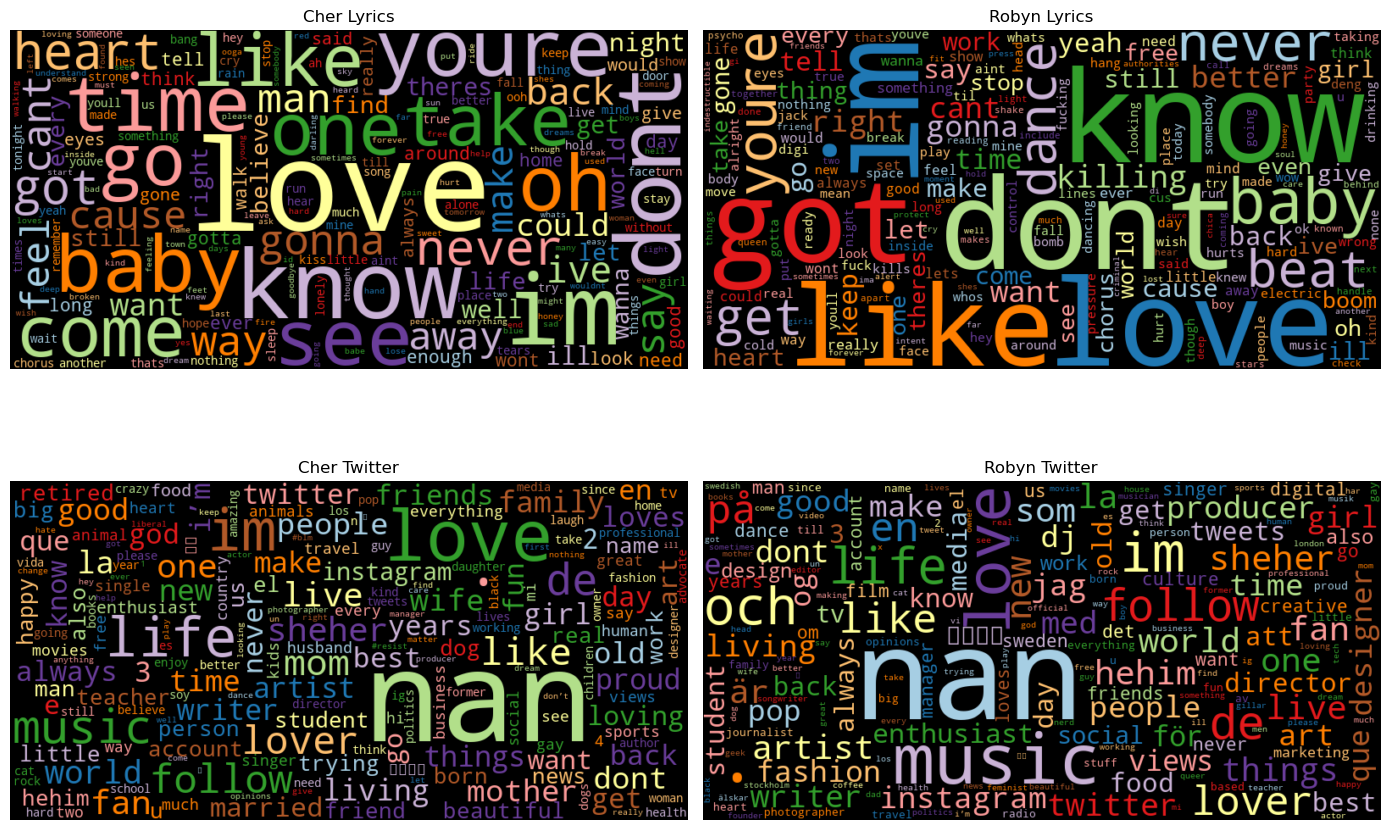

In [19]:
# plot wordclouds
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plt.sca(axes[0, 0])
wordcloud(wc_cher_lyrics, title="Cher Lyrics")

plt.sca(axes[0, 1])
wordcloud(wc_robyn_lyrics, title="Robyn Lyrics")

plt.sca(axes[1, 0])
wordcloud(wc_cher_twitter, title="Cher Twitter")

plt.sca(axes[1, 1])
wordcloud(wc_robyn_twitter, title="Robyn Twitter")

plt.tight_layout()
plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds?

A: From the lyrics, the words that stick out the most have a theme related to love and relationships. The largest words in the lyrics wordclouds are also the top words in the unique words copora. Robyn's lyrics also show "beat" and "dance" which suggests there are some differences between her music style (Electropop/Dancepop) compared to Cher (Pop/Rock). For the twitter wordclouds, the largest word appears to be "nan" or "Not a Number" which suggests that most of the tokens were emojis or non-English words. In Robyn's twitter, there are some non-English words also showing that her fanbase is not English-speaking only. Overall, other than "nan", the most visible words in the twitter wordclouds show a theme of love and music suggesting that their fans show their appreciation for their work.
